# Iterative linear discriminant

Author: Aleksander Filip Żarnecki (University of Warsaw)

### (0) Import libraries 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### (1) Define 2D sample generation procedure

In [2]:
# Generate 2D normal distributed sample using method from lecture 4

def mydata(Nmc,pos,sig,corr=0.0):

    data = np.empty(shape=(Nmc,2))
    
    phi = 0.5*np.arcsin(corr)

    g = np.random.normal(size=(2,Nmc))

    data[:,0] = pos[0] + sig[0]*(g[0]*np.cos(phi) + g[1]*np.sin(phi))
    data[:,1] = pos[1] + sig[1]*(g[0]*np.sin(phi) + g[1]*np.cos(phi))
    
    return data

### (2) Generating data

In [3]:
# Test data consist of two 2D event samples
# one generated from H1 hypothesis and one from H2

# Events per sample

Nmc = 50

# Measurement uncertainties and correlation (same for both hypothesis)

sig = np.array([1.2,0.6])
corr = -0.5

# Nominal values for each case (2D)

h1 = np.array([-1.,-1.])
h2 = np.array([1.,1.])


X = np.empty(shape=(2*Nmc,2))
y = np.empty(shape=(2*Nmc))


X[:Nmc,:] = mydata(Nmc,h1,sig,corr)
y[:Nmc] = -1

X[Nmc:,:] = mydata(Nmc,h2,sig,corr)
y[Nmc:] = 1

print("Test data defined, size: ",y.size)

Test data defined, size:  100


### (3) Calculate expected covariance matrix

In [4]:
# Expected covariance matrix of the measurements
# (same for both hypothesis)

acorr = np.array([[1.,corr],[corr,1.]])

cov = np.outer(sig,sig) * acorr

### (4) Calculate linear discriminant (for reference)

In [5]:
cinv = np.linalg.inv(cov+cov)

w = cinv @ ( h2 - h1 )

norm = np.sum(w*w)

w /= np.sqrt(norm)

print("Reference discriminant coefficients: w0 = %.4f   w1 = %.4f"%(w[0],w[1]))

Reference discriminant coefficients: w0 = 0.3714   w1 = 0.9285


In [6]:
# Division line should cross in the middle between h1 and h2

h0 = 0.5*(h1+h2)

w0 = w @ h0

# Coefficients for the line    w @ h = w0

aw = -w[0]/w[1]
bw = w0/w[1]

print("Reference discriminant line: y = %.4f * x  +  %.4f"%(aw,bw))

Reference discriminant line: y = -0.4000 * x  +  0.0000


### (5) Iterative approach

In [7]:
# Start from random weights and offset (!)

wvec = 2.0*np.random.uniform(size=2)-1.0
wcut = 2.0*np.random.uniform()-1.0

nwv = np.sqrt(np.sum(wvec*wvec))
print("Initial coefficients: ",wvec[0]/nwv,", ",wvec[1]/nwv)
    

# Initial prediction

ypred  = np.tanh( (X @ wvec) - wcut) 
dy = ypred - y
dist = np.sum(dy*dy)
nok = np.sum(ypred*y > 0)

# Iteration starting step

eta = 0.01

it = 0
dmin = dist
print("Initial distance: ",np.sqrt(dist),", ",nok," events properly classified")

# Debug printout
# print(it,eta,wvec,wcut,nok,dist)
  
while True :

    it+=1
    
    dw = dy @ X

    cutnew = wcut + eta/Nmc * np.sum(dy)
    wnew = wvec - eta/Nmc * dw
    
    ypred  = np.tanh( (X @ wnew) - cutnew) 
    
    nok = np.sum(ypred*y > 0)

    dy = ypred - y
    dist = np.sum(dy*dy)

# Debug printout
#    if it%10 == 0 :
#        print(it,eta,wnew,cutnew,nok,dist)
  
    if dist < dmin :
        wcut = cutnew
        wvec = wnew
        eta *= 2.0
        dmin = dist
    else:
        eta /= 2.
        
    if eta < 0.0000001 : break
    
    if nok == 2*Nmc : break
    
    if it == 1000 : break

  
# Normalized direction vector

nwv = np.sqrt(np.sum(wvec*wvec))

print(it," iterations, final distance: ",np.sqrt(dist),", ",nok," events properly classified")
print("Final coefficients: ",wvec[0]/nwv,", ",wvec[1]/nwv)
    
ai = -wvec[0]/wvec[1]
bi = wcut/wvec[1]

print("Discriminant line: y = ",ai," * x  +  ",bi)

Initial coefficients:  0.0016582690451820566 ,  -0.9999986250709418
Initial distance:  14.440771408387482 ,  29  events properly classified
7  iterations, final distance:  2.3529311160444633 ,  100  events properly classified
Final coefficients:  0.6593733220884731 ,  0.751815683607366
Discriminant line: y =  -0.8770411903681825  * x  +   -0.1340718069798048


### (6) Plot results

In [8]:
# Create result graph

Xmin = -5.0
Xmax = 5.0
Np = 2

Xfun = np.linspace(Xmin,Xmax,Np)

# Discriminant line from the generated sample and from the distribution parameters

Yifun = ai*Xfun + bi
Ywfun = aw*Xfun + bw

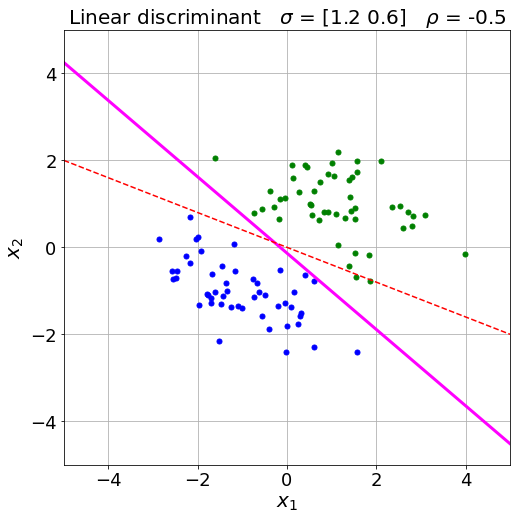

In [9]:
plt.figure(figsize=(8, 8))

# Training points in two categories

plt.plot(X[:Nmc,0],X[:Nmc,1],'o',color='blue',ms=5)
plt.plot(X[Nmc:,0],X[Nmc:,1],'o',color='green',ms=5)

plt.title("Linear discriminant   $\sigma$ = "+str(sig)+"   $\\rho$ = "+str(corr),size=20)
plt.xlabel('$x_1$',size=20)
plt.ylabel('$x_2$',size=20)

plt.plot(Xfun,Yifun,'-',color='magenta',linewidth=3)
plt.plot(Xfun,Ywfun,'--',color='red')

plt.xlim([Xmin,Xmax])
plt.ylim([Xmin,Xmax])

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(which='major', axis='both')

if Nmc == 50 :
    fname = '12_Iterative_'+str(sig[0])+'_'+str(sig[1])+'_'+str(corr)+'.png'
else :
    fname = '12_Iterative_'+str(sig[0])+'_'+str(sig[1])+'_'+str(corr)+'_'+str(2*Nmc)+'.png'
    

plt.savefig(fname)

plt.show()